## Data PreProcessing

In [192]:
import numpy as np
import yfinance as yf
import pandas as pd

from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten

In [193]:
# msft = yf.Ticker("MSFT")
msft = yf.Ticker("RELIANCE.NS")

In [194]:
#Processing data fro data set
hist = msft.history(period="max")
del hist['Dividends']
del hist['Stock Splits']
del hist['Volume']

hist['Avg_low_high'] = (hist['Low'] + hist['High'])/2
hist['Avg_open_close'] = ( hist['Open'] + hist['Close'] )/2

del hist['Open']
del hist['High']
del hist['Low']
del hist['Close']
print(type(hist))
hist

<class 'pandas.core.frame.DataFrame'>


,Avg_low_high,Avg_open_close
Date,,
1996-01-01 00:00:00+05:30,10.433430,10.458893
1996-01-02 00:00:00+05:30,10.411787,10.424518
1996-01-03 00:00:00+05:30,10.750444,10.521278
1996-01-04 00:00:00+05:30,10.323941,10.377413
1996-01-05 00:00:00+05:30,10.278106,10.322666
...,...,...
2023-05-22 00:00:00+05:30,2449.175049,2445.000000
2023-05-23 00:00:00+05:30,2459.724976,2457.599976
2023-05-24 00:00:00+05:30,2448.724976,2443.074951


In [196]:
full_length = len(hist)
required_time_frame_in_days = (2023 - 1990)*252
# back_shift = 0 number of days to go back from now eg 10 so 27th may - 10 = 17 may
back_shift = 0
hist = hist[(full_length - back_shift - required_time_frame_in_days) : (full_length - back_shift)]
print(len(hist))
hist

1428


,Avg_low_high,Avg_open_close
Date,,
2017-08-16 00:00:00+05:30,757.640171,760.524115
2017-08-17 00:00:00+05:30,765.540867,760.039458
2017-08-18 00:00:00+05:30,758.791346,760.839237
2017-08-21 00:00:00+05:30,762.050945,761.323897
2017-08-22 00:00:00+05:30,760.003142,759.057964
...,...,...
2023-05-22 00:00:00+05:30,2449.175049,2445.000000
2023-05-23 00:00:00+05:30,2459.724976,2457.599976
2023-05-24 00:00:00+05:30,2448.724976,2443.074951


In [180]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

Enter the number of days the lstm model should acount for while giving a prediction ,  somewhat equal to no of points duirng linear regresion . 

In [181]:
# define input sequence
timeseries_data = hist['Avg_low_high']
# choose a number of time steps
n_steps = int(input("Enter the no. of fsteps :  "))
#n_steps = 3
# split into samples
X, y = prepare_data(timeseries_data, n_steps)
#
print(X),print(y)

Enter the no. of fsteps :  3
[[ 429.416028    423.11805769  427.386714  ]
 [ 423.11805769  427.386714    422.67491701]
 [ 427.386714    422.67491701  417.44994425]
 ...
 [1333.9369792  1283.70463927 1239.00759848]
 [1283.70463927 1239.00759848 1230.30216646]
 [1239.00759848 1230.30216646 1213.52562104]]
[ 422.67491701  417.44994425  417.33333227 ... 1230.30216646 1213.52562104
 1219.6462184 ]


(None, None)

In [182]:
X.shape

(1425, 3)

In [183]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
type(X)

numpy.ndarray

In [184]:

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=10, verbose=1)


Epoch 1/10
45/45 [==============================] - 4s 10ms/step - loss: 414559.7188
Epoch 2/10
45/45 [==============================] - 0s 10ms/step - loss: 18148.0254
Epoch 3/10
45/45 [==============================] - 0s 10ms/step - loss: 303.4307
Epoch 4/10
45/45 [==============================] - 0s 10ms/step - loss: 264.5411
Epoch 5/10
45/45 [==============================] - 0s 6ms/step - loss: 264.0043
Epoch 6/10
45/45 [==============================] - 0s 6ms/step - loss: 259.5194
Epoch 7/10
45/45 [==============================] - 0s 6ms/step - loss: 262.7387
Epoch 8/10
45/45 [==============================] - 0s 6ms/step - loss: 260.8047
Epoch 9/10
45/45 [==============================] - 0s 6ms/step - loss: 259.0963
Epoch 10/10
45/45 [==============================] - 0s 6ms/step - loss: 264.1968


In [185]:
#N = int(input("Enter no. of days"))
No_of_days = 20
# len(hist['Avg_low_high'])-n_steps

In [186]:
# demonstrate prediction for next N days
hist_len = len(hist['Avg_low_high'])
# x_input = np.array([
#                     hist['Avg_low_high'][hist_len - 3], Previous method for 3 stage data
#                     hist['Avg_low_high'][hist_len - 2],
#                     hist['Avg_low_high'][hist_len - 1]])
x_input = np.array([hist['Avg_low_high'][hist_len - n_steps:hist_len]])

temp_input=list(x_input)
lst_output=[]
i=0
while(i<No_of_days):
    
    if(len(temp_input)>n_steps): #here 3 was replaced by n_steps was 
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, n_features))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
print(lst_output)
print("Done")

[1229.967]
[1229.967]
[1229.967]
3 day input [1229.967 1229.967 1229.967]
3 day output [[1237.4524]]
4 day input [1229.967  1229.967  1237.4524]
4 day output [[1238.616]]
5 day input [1229.967  1237.4524 1238.616 ]
5 day output [[1241.5475]]
6 day input [1237.4524 1238.616  1241.5475]
6 day output [[1246.0482]]
7 day input [1238.616  1241.5475 1246.0482]
7 day output [[1248.3872]]
8 day input [1241.5475 1246.0482 1248.3872]
8 day output [[1251.8215]]
9 day input [1246.0482 1248.3872 1251.8215]
9 day output [[1255.3899]]
10 day input [1248.3872 1251.8215 1255.3899]
10 day output [[1258.3368]]
11 day input [1251.8215 1255.3899 1258.3368]
11 day output [[1261.7657]]
12 day input [1255.3899 1258.3368 1261.7657]
12 day output [[1265.1061]]
13 day input [1258.3368 1261.7657 1265.1061]
13 day output [[1268.3093]]
14 day input [1261.7657 1265.1061 1268.3093]
14 day output [[1271.6918]]
15 day input [1265.1061 1268.3093 1271.6918]
15 day output [[1275.0088]]
16 day input [1268.3093 1271.6918 12

In [187]:
# hist_len = len(hist['Avg_low_high'])
# print(hist['Avg_low_high'][hist_len - 3])
# print(hist['Avg_low_high'][hist_len - 2])
# print(hist['Avg_low_high'][hist_len - 1])
# hist

## Visualising the output

In [188]:
import matplotlib.pyplot as plt

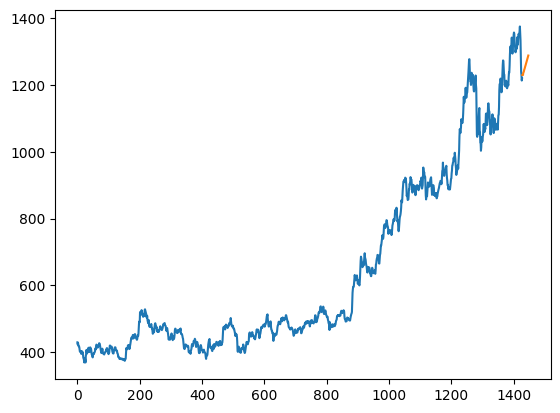

In [189]:
day_new=np.arange(0,hist_len)
day_pred=np.arange(hist_len,hist_len+No_of_days)
plt.plot(day_new,timeseries_data)
plt.plot(day_pred,lst_output)